In [ ]:
!pip install transformers datasets sacrebleu peft


In [ ]:
!pip install datasets

## Connect to Drive

In [ ]:
from google.colab import drive
import pandas as pd
from datasets import Dataset

In [ ]:

drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


##Load dataset

In [ ]:
file_path = '/content/drive/MyDrive/dataset/combined_dataset_final.tsv'


In [ ]:
import os
output_dir = "/content/drive/MyDrive/mbart-finetuned-ur-en-final-v3"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


##Split dataset, convert to hugging face format

In [ ]:
# Read the dataset
df = pd.read_csv(file_path, sep='\t')
print(f"Total entries before splitting: {len(df)}")

# Shuffle entire dataset
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Step 1: Set aside 50,000 for test (outside of training/val)
test_df = df.iloc[:50_000]

# Step 2: Take next 500,000 for training + validation
train_val_df = df.iloc[50_000:250_000]

# Rename for HuggingFace format
train_val_df = train_val_df.rename(columns={"en": "translation_en", "ur": "translation_ur"})
test_df = test_df.rename(columns={"en": "translation_en", "ur": "translation_ur"})

# Create "translation" columns
train_val_df["translation"] = train_val_df.apply(lambda row: {"en": row["translation_en"], "ur": row["translation_ur"]}, axis=1)
test_df["translation"] = test_df.apply(lambda row: {"en": row["translation_en"], "ur": row["translation_ur"]}, axis=1)

# Convert to HuggingFace Datasets
from datasets import Dataset
train_val_dataset = Dataset.from_pandas(train_val_df[["translation"]])
test_dataset = Dataset.from_pandas(test_df[["translation"]])


Total entries before splitting: 923768


##Load the pretrained mbart model, apply LoRA, load checkpoints

In [ ]:
import glob
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from peft import LoraConfig, get_peft_model, PeftModel
import os
model_name = "facebook/mbart-large-50-many-to-many-mmt"

# Load base model
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Applying LoRA -- using default config values
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)

# Load tokenizer
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
tokenizer.src_lang = "ur_PK"
target_lang = "en_XX"

# Check if checkpoint exists
checkpoint_paths = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*")), key=lambda x: int(x.split("-")[-1]))

if checkpoint_paths:
    latest_checkpoint_path = checkpoint_paths[-1]
    print(f" Loading LoRA checkpoint from: {latest_checkpoint_path}")
    # model = PeftModel.from_pretrained(model, latest_checkpoint_path)
else:
    print("No checkpoint found, training will start fresh.")

# latest_checkpoint_path = checkpoint_paths[-1] if checkpoint_paths else None



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


 Loading LoRA checkpoint from: /content/drive/MyDrive/mbart-finetuned-ur-en-final-v3/checkpoint-17705


In [ ]:
print(tokenizer.lang_code_to_id.keys())


dict_keys(['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI'])


##Testing tokenizer

In [ ]:
# Input: Urdu sentence
text = "اور نجات کا خود اور روح کی تلوار جو خدا کا کلام ہے لے لو"

# Tokenize
inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True)

# Generate English translation
generated_tokens = model.generate(
    **inputs,
    forced_bos_token_id=tokenizer.lang_code_to_id[target_lang]
)

# Decode output
translation = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print("Translated:", translation)


Translated: Take the sword of salvation, the sword of the spirit, the word of God.


## Tokenize the input data, save it to drive

In [ ]:
from datasets import load_from_disk, DatasetDict
import os
tokenized_dataset_path = "file:///content/drive/MyDrive/mbart-tokenized-ur-en-final-v3"

def preprocess(example):
    tokenizer.src_lang = "ur_PK"

    # Tokenize source (Urdu)
    model_inputs = tokenizer(
        example['translation']['ur'],
        truncation=True,
        max_length=128
    )

    # Tokenize target (English)
    labels = tokenizer(
        example['translation']['en'],
        truncation=True,
        max_length=96
    )["input_ids"]

     # mask pads so they’re ignored by CE loss
    labels = [
        (-100 if tok == tokenizer.pad_token_id else tok)
        for tok in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs


if os.path.exists(tokenized_dataset_path):
    print(" Loading pre-tokenized dataset from Drive...")

    tokenized_dataset = load_from_disk(tokenized_dataset_path)
else:
    print(" No tokenized dataset found, preprocessing and splitting now...")

    #Tokenize training/validation and test separately
    tokenized = train_val_dataset.map(preprocess)
    tokenized_test = test_dataset.map(preprocess)

    split = tokenized.train_test_split(test_size=0.15, seed=42)

    # Build DatasetDict with external test set
    tokenized_dataset = DatasetDict({
        "train":      split["train"],
        "validation": split["test"],
        "test":       tokenized_test  # using the separate test set
    })

    tokenized_dataset.save_to_disk(tokenized_dataset_path)
    print("Tokenized dataset saved successfully!")


 No tokenized dataset found, preprocessing and splitting now...


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/170000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/30000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenized dataset saved successfully!


In [ ]:
# after loading your tokenizer:
print("total vocab size:", tokenizer.vocab_size)
# or equivalently:
print("total vocab size:", len(tokenizer.get_vocab()))


total vocab size: 250054
total vocab size: 250054


In [ ]:
model = model.to("cuda")


In [ ]:
import json
from transformers import TrainerCallback

In [ ]:
class LossTrackerCallback(TrainerCallback):
    def __init__(self, save_path, save_every_steps=1000):
        self.train_losses = []
        self.eval_losses = []
        self.save_path = save_path
        self.save_every_steps = save_every_steps

        # Try loading old loss file
        if os.path.exists(save_path):
            with open(save_path, "r") as f:
                data = json.load(f)
                self.train_losses = data.get("train_losses", [])
                self.eval_losses = data.get("eval_losses", [])
                print(" Loaded previous loss history.")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            step = state.global_step

            if 'loss' in logs:
                self.train_losses.append((step, logs['loss']))
            if 'eval_loss' in logs:
                self.eval_losses.append((step, logs['eval_loss']))

            # Save only every N steps
            if step % self.save_every_steps == 0:
                self.save_to_file()

    def save_to_file(self):
        data = {
            "train_losses": self.train_losses,
            "eval_losses": self.eval_losses
        }
        with open(self.save_path, "w") as f:
            json.dump(data, f)
        print(f" Loss saved to {self.save_path} (steps: {len(self.train_losses)})")


In [ ]:
!pip install evaluate
!pip install bert_score

## Training config

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
os.environ["WANDB_DISABLED"] = "true"
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)
loss_tracker = LossTrackerCallback(
    "/content/drive/MyDrive/mbart-finetune-losses-final-v2.json",
    save_every_steps=1000
)

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    # per_device_train_batch_size=16,
    # gradient_accumulation_steps=4,
    per_device_train_batch_size= 12,
    gradient_accumulation_steps= 4,         # effective batch = 64×2 = 128
    num_train_epochs=5,
    logging_steps=200,
    save_steps=1000,
    save_strategy="steps",
    eval_strategy="steps",
    eval_steps=1000,
    save_total_limit=2,
    fp16=True,
    predict_with_generate=False, #skipping genertaion during training to speed up
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-5,  #2e-5 did not work well   ##default 0.00005
     warmup_ratio=0.03,
  lr_scheduler_type="cosine",
    weight_decay=0.01,


)
training_args.label_names = ["labels"]

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_tracker]

)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


 Loaded previous loss history.


<ipython-input-18-033d28be456c>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
##start fine tuning
# model.train()

if checkpoint_paths:
    trainer.train(resume_from_checkpoint=latest_checkpoint_path)
else:
    trainer.train()





Step,Training Loss,Validation Loss


## Evaluate using BLEU, BERT and METEOR scores

In [ ]:
import os
import torch
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from evaluate import load
from transformers import (
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    DataCollatorForSeq2Seq
)
from datasets import load_from_disk, Dataset

# 1) Load metrics once
_bleu_metric      = load("sacrebleu")
_bertscore_metric = load("bertscore")
_meteor_metric    = load("meteor")

# 2) Unified evaluation function with BLEU, BERTScore, METEOR, and beam search
def evaluate_model(model,
                   tokenizer: MBart50TokenizerFast,
                   tokenized_test: Dataset,
                   label: str = "Eval",
                   batch_size: int = 32,
                   limit: int = None):
    """
    Generate translations for `limit` examples (or full set if None),
    then compute BLEU, BERTScore, and METEOR.
    """
    ds = tokenized_test
    if limit is not None:
        ds = ds.select(range(limit))
        print(f"🔎 Evaluating on first {limit} examples")

    model = model.eval().to("cuda")
    collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)
    loader   = DataLoader(ds, batch_size=batch_size, collate_fn=collator)

    all_preds, all_refs = [], []
    for batch in tqdm(loader, desc=label):
        batch = {k: v.to("cuda") for k, v in batch.items()}
        with torch.no_grad():
            out = model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
                max_length=96,
                num_beams=4,
                length_penalty=1.2,
                early_stopping=True
            )
        preds = tokenizer.batch_decode(out, skip_special_tokens=True)
        all_preds.extend(preds)

        labs = batch["labels"].clone().cpu().numpy()
        labs[labs == -100] = tokenizer.pad_token_id
        refs = tokenizer.batch_decode(labs, skip_special_tokens=True)
        all_refs.extend(refs)

    bleu = _bleu_metric.compute(predictions=all_preds, references=[[r] for r in all_refs])["score"]
    bert = _bertscore_metric.compute(predictions=all_preds, references=all_refs, lang="en")
    meteor = _meteor_metric.compute(predictions=all_preds, references=[[r] for r in all_refs])["meteor"]

    print(f"\n{label} → BLEU: {bleu:.2f}")
    print(f"{label} → BERTScore P: {np.mean(bert['precision']):.4f}, "
          f"R: {np.mean(bert['recall']):.4f}, "
          f"F1: {np.mean(bert['f1']):.4f}")
    print(f"{label} → METEOR: {meteor:.2f}")

    return {
        "bleu": bleu,
        "bertscore_precision": np.mean(bert["precision"]),
        "bertscore_recall":    np.mean(bert["recall"]),
        "bertscore_f1":        np.mean(bert["f1"]),
        "meteor": meteor
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


##mBART vs Fine tuned model

In [ ]:
import bitsandbytes
tokenized_test_path = "/content/drive/MyDrive/mbart-tokenized-eval-test"
tokenized_test = get_tokenized_test_dataset(test_dataset, tokenized_test_path, tokenizer)



model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer  = MBart50TokenizerFast.from_pretrained(model_name)
tokenizer.src_lang = "ur_PK"

quant_model = MBartForConditionalGeneration.from_pretrained(
    model_name,
    device_map="auto"
)
baseline_scores = evaluate_model(
    quant_model,
    tokenizer,
    tokenized_test,
    label="MBART 10k",
    batch_size=16,
    limit=10000
)

fine_tuned_model = model
fine_scores = evaluate_model(
    fine_tuned_model,
    tokenizer,
    tokenized_test,
    label="Fine-tuned MBART 10k",
    batch_size=16,
    limit=10000
)

results = [
    {"model": "MBART", **baseline_scores},
    {"model": "Fine-tuned LoRA", **fine_scores}
]


df = pd.DataFrame(results)

csv_path = "/content/drive/MyDrive/eval_scores.csv"
df.to_csv(csv_path, index=False)
print("Saved evaluation scores to:", csv_path)
print("Baseline →", baseline_scores)
print("Fine-tuned LoRA  →", fine_scores)


ModuleNotFoundError: No module named 'bitsandbytes'

## Plot results

<Figure size 400x300 with 0 Axes>

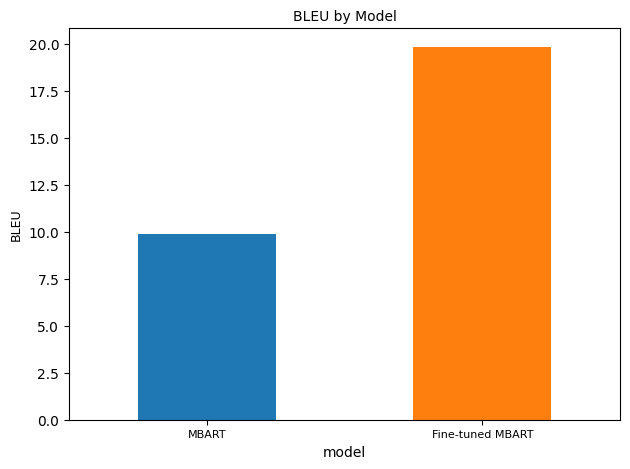

<Figure size 400x300 with 0 Axes>

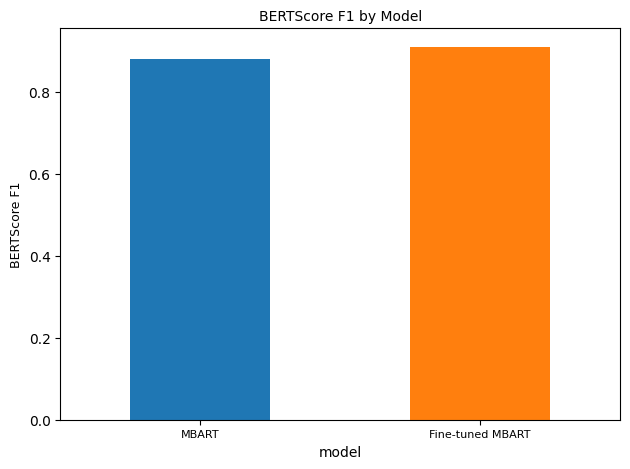

<Figure size 400x300 with 0 Axes>

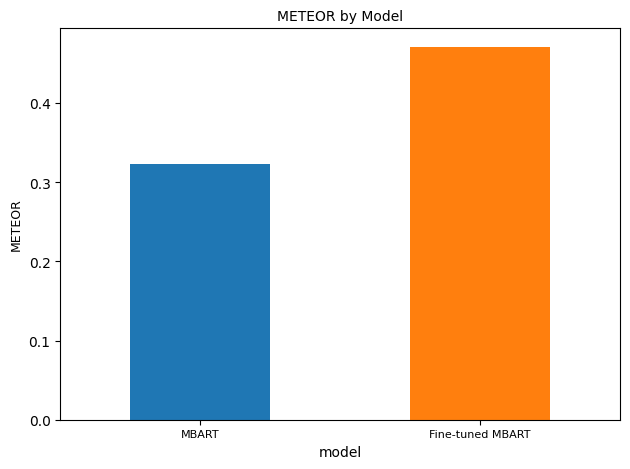

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload results if needed
csv_path = "/content/drive/MyDrive/eval_scores.csv"
df = pd.read_csv(csv_path)

# Rename model labels
df["model"] = df["model"].replace({
    "Quantized MBART": "MBART",
    "Fine-tuned LoRA": "Fine-tuned MBART"
})

# Define plotting parameters
metrics = [
    ("bleu", "BLEU"),
    ("bertscore_f1", "BERTScore F1"),
    ("meteor", "METEOR")
]
colors = ["#1f77b4", "#ff7f0e"]  # blue for MBART, orange for fine-tuned

for col, label in metrics:
    plt.figure(figsize=(4, 3))
    ax = df.plot.bar(
        x="model",
        y=col,
        legend=False,
        color=colors
    )
    ax.set_title(f"{label} by Model", fontsize=10)
    ax.set_ylabel(label, fontsize=9)
    ax.set_xticklabels(df["model"], rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()



## Test transation on urdu sentences

In [ ]:
# # Sample Urdu sentences
# urdu_sentences = [
#     "میں آج یونیورسٹی جا رہا ہوں۔",
#     "اس کتاب نے میرے خیالات کو ایک نئی جہت دی ہے",
#     "کیا آپ میری مدد کر سکتے ہیں؟",
#     "ہم کل لاہور جائیں گے۔",
#     "مجھے اردو سے انگریزی ترجمہ سیکھنا ہے۔"
# ]

urdu_sentences = [
    "طلبا کو چاہیے کہ وہ امتحان کی تیاری دلجمعی سے کریں۔",
    "ہمیں قومی ترقی کے لیے تعلیم کو ترجیح دینی چاہیے۔",
    "یہ کتاب قاری کی سوچ کو متاثر کرنے کی صلاحیت رکھتی ہے۔",
    "معاشرتی ہم آہنگی کے بغیر ترقی ممکن نہیں۔",
    "اچھی قیادت قوموں کو بحرانوں سے نکالنے میں مدد دیتی ہے۔"
]

tokenizer.src_lang = "ur_PK"
target_lang = "en_XX"
fine_tuned_model = model
fine_tuned_model.eval()

# Translate using both models
def translate_sentences(model, sentences, label):
    translations = []
    for sent in sentences:
        inputs = tokenizer(sent, return_tensors="pt", truncation=True, max_length=128).to("cuda")
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[target_lang],
                max_length=96,
                num_beams=4,
                early_stopping=True
            )
        translated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(translated)
    return translations

# Get translations
baseline_translations = translate_sentences(baseline_model, urdu_sentences, "MBART")
fine_tuned_translations = translate_sentences(fine_tuned_model, urdu_sentences, "Fine-tuned MBART")

print("=" * 100)
for i, (ur, base, fine) in enumerate(zip(urdu_sentences, baseline_translations, fine_tuned_translations), 1):
    print(f"🔢 Sentence {i}")
    print(f"🟢 Urdu:               {ur}")
    print(f"🔵 Baseline MBART:     {base}")
    print(f"🟠 Fine-tuned MBART:   {fine}")
    print("-" * 100)


🔢 Sentence 1
🟢 Urdu:               طلبا کو چاہیے کہ وہ امتحان کی تیاری دلجمعی سے کریں۔
🔵 Baseline MBART:     The demand is that they prepare for the exams in a calm setting.
🟠 Fine-tuned MBART:   Students should prepare for the examination in a spirited manner
----------------------------------------------------------------------------------------------------
🔢 Sentence 2
🟢 Urdu:               ہمیں قومی ترقی کے لیے تعلیم کو ترجیح دینی چاہیے۔
🔵 Baseline MBART:     We were told to prioritize education for national progress.
🟠 Fine-tuned MBART:   We must give priority to education for national development
----------------------------------------------------------------------------------------------------
🔢 Sentence 3
🟢 Urdu:               یہ کتاب قاری کی سوچ کو متاثر کرنے کی صلاحیت رکھتی ہے۔
🔵 Baseline MBART:     These books are capable of affecting the thinking of the continent.
🟠 Fine-tuned MBART:   This book has the power to influence the thinking of the reader.
-----------------------

## Plotting the Validation vs Traning loss

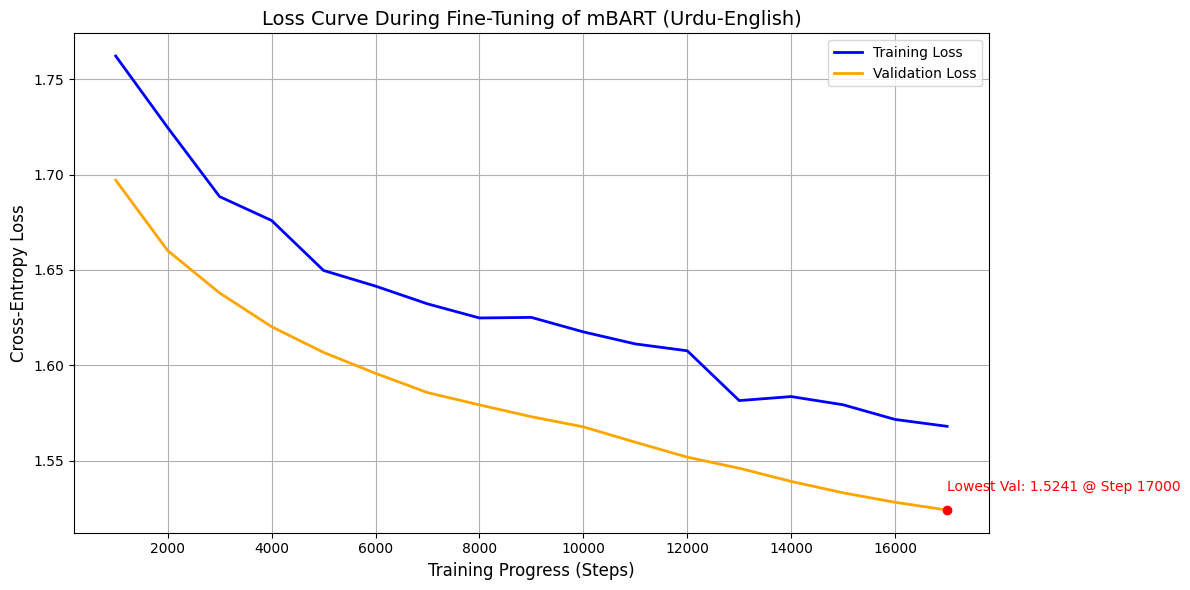

In [ ]:
import json
import matplotlib.pyplot as plt

# Load your loss file
loss_path = "/content/drive/MyDrive/mbart-finetune-losses-final-v2.json"
with open(loss_path, "r") as f:
    data = json.load(f)

# Filter + deduplicate steps (keep latest for each step, only steps >= 1000 in multiples of 1000)
def clean(loss_list):
    clean_dict = {}
    for step, loss in loss_list:
        if step >= 1000 and step % 1000 == 0:
            clean_dict[step] = loss
    return sorted(clean_dict.items())

train = clean(data["train_losses"])
eval_ = clean(data["eval_losses"])

train_steps, train_vals = zip(*train)
eval_steps, eval_vals = zip(*eval_)

# Identify best validation loss
best_val = min(eval_vals)
best_step = eval_steps[eval_vals.index(best_val)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_vals, label="Training Loss", color="blue", linewidth=2)
plt.plot(eval_steps, eval_vals, label="Validation Loss", color="orange", linewidth=2)

# Mark lowest validation loss
plt.scatter([best_step], [best_val], color="red", zorder=5)
plt.text(best_step, best_val + 0.01, f"Lowest Val: {best_val:.4f} @ Step {best_step}", color="red")

# Styling
plt.xlabel("Training Progress (Steps)", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.title("Loss Curve During Fine-Tuning of mBART (Urdu-English)", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()

# Save high-res plot
plt.savefig("/content/drive/MyDrive/loss_curve_final.png", dpi=300, bbox_inches='tight')
plt.show()



##Testing

# Instructions for Using Fine-Tuned Urdu-to-English Translation Model


We have provided you with the following two zip files:
1. **`mbart_lora_finetuned_save.zip`** — (Model LoRA Adapter)
2. **`mbart_tokenizer_save.zip`** — (Tokenizer)

Please follow these steps to load the model and perform translation:

---

### **Step-by-Step Instructions**

1. **Upload the two zip files** to your Colab environment.
   - Click the folder 📂 icon (left side in Colab).
   - Click `Upload` and select both:
     - `mbart_lora_finetuned_save.zip`
     - `mbart_tokenizer_save.zip`

2. **Unzip the files** (Run this cell):
```python
!unzip -o mbart_lora_finetuned_save.zip
!unzip -o mbart_tokenizer_save.zip


##Run this cell for testing now

In [3]:
# 1. Install necessary libraries
!pip install transformers peft

# 2. Imports
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from peft import PeftModel

# 3. Load Model and Tokenizer from Local Directory
model_load_path = "/content/mbart_lora_finetuned_save"
tokenizer_load_path = "/content/mbart_tokenizer_save"


tokenizer = MBart50TokenizerFast.from_pretrained(tokenizer_load_path)
tokenizer.src_lang = "ur_PK"
target_lang = "en_XX"

base_model_name = "facebook/mbart-large-50-many-to-many-mmt"
model = MBartForConditionalGeneration.from_pretrained(base_model_name)

model = PeftModel.from_pretrained(model, model_load_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Input your urdu senteences
urdu_sentences = [
    "طلبا کو چاہیے کہ وہ امتحان کی تیاری دلجمعی سے کریں۔",
    "ہمیں قومی ترقی کے لیے تعلیم کو ترجیح دینی چاہیے۔",
    "یہ کتاب قاری کی سوچ کو متاثر کرنے کی صلاحیت رکھتی ہے۔",
    "معاشرتی ہم آہنگی کے بغیر ترقی ممکن نہیں۔",
    "اچھی قیادت قوموں کو بحرانوں سے نکالنے میں مدد دیتی ہے۔"
]

# Translation Function
def translate_sentences(model, tokenizer, sentences):
    translations = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", max_length=128, truncation=True).to(device)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[target_lang],
                max_length=96,
                num_beams=4,
                early_stopping=True
            )
        translated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        translations.append(translated)
    return translations

# Run Translation
translations = translate_sentences(model, tokenizer, urdu_sentences)

#Display Translations
for ur, en in zip(urdu_sentences, translations):
    print(f"🟢 Urdu: {ur}")
    print(f"🔵 English: {en}")
    print("-" * 100)


🟢 Urdu: طلبا کو چاہیے کہ وہ امتحان کی تیاری دلجمعی سے کریں۔
🔵 English: Students should prepare for the examination in a spirited manner.
----------------------------------------------------------------------------------------------------
🟢 Urdu: ہمیں قومی ترقی کے لیے تعلیم کو ترجیح دینی چاہیے۔
🔵 English: Make education a priority for national development
----------------------------------------------------------------------------------------------------
🟢 Urdu: یہ کتاب قاری کی سوچ کو متاثر کرنے کی صلاحیت رکھتی ہے۔
🔵 English: This book is able to touch the mind of the reader.
----------------------------------------------------------------------------------------------------
🟢 Urdu: معاشرتی ہم آہنگی کے بغیر ترقی ممکن نہیں۔
🔵 English: Social progress is not possible without friendship
----------------------------------------------------------------------------------------------------
🟢 Urdu: اچھی قیادت قوموں کو بحرانوں سے نکالنے میں مدد دیتی ہے۔
🔵 English: Good leadership helps people ou